## Load Data and Packages

In [142]:
# Download data from kaggle
import kagglehub
path = kagglehub.dataset_download("luizclaudioandrade/naip-chesapeake-sample")

print("Path to dataset files:", path)

Path to dataset files: /Users/bermane/.cache/kagglehub/datasets/luizclaudioandrade/naip-chesapeake-sample/versions/7


In [143]:
# load packages
# import semantic_seg_custom_classes
import lightning as L # Instead of import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, RasterDataset
from torchgeo.datasets.splits import random_bbox_assignment
from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler, GridGeoSampler
import os
import matplotlib.pyplot as plt
import numpy as np
from torchgeo.trainers import SemanticSegmentationTask
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import ssl
import multiprocessing as mp
from torchgeo.datamodules import GeoDataModule
from typing import Type
import albumentations as A
import timeit
import torch
import numpy as np
from rasterio.plot import show
from rasterio.merge import merge
import rasterio
from rasterio.transform import from_bounds, from_origin
from rasterio.crs import CRS
from rasterio.io import MemoryFile

## Initialize Parameters

In [144]:
# define landcover labels
"""
Complete 13-class dataset.

    This version of the dataset is composed of 13 classes:

    0. No Data: Background values
    1. Water: All areas of open water including ponds, rivers, and lakes
    2. Wetlands: Low vegetation areas located along marine or estuarine regions
    3. Tree Canopy: Deciduous and evergreen woody vegetation over 3-5 meters in height
    4. Shrubland: Heterogeneous woody vegetation including shrubs and young trees
    5. Low Vegetation: Plant material less than 2 meters in height including lawns
    6. Barren: Areas devoid of vegetation consisting of natural earthen material
    7. Structures: Human-constructed objects made of impervious materials
    8. Impervious Surfaces: Human-constructed surfaces less than 2 meters in height
    9. Impervious Roads: Impervious surfaces that are used for transportation
    10. Tree Canopy over Structures: Tree cover overlapping impervious structures
    11. Tree Canopy over Impervious Surfaces: Tree cover overlapping impervious surfaces
    12. Tree Canopy over Impervious Roads: Tree cover overlapping impervious roads
    13. Aberdeen Proving Ground: U.S. Army facility with no labels
"""

names=[
    'No Data',
    'Water',
    'Wetlands',
    'Tree Canopy',
    'Shrubland',
    'Low Vegetation',
    'Barren',
    'Structures',
    'Impervious Surfaces',
    'Impervious Roads',
    'Tree Canopy over Structures',
    'Tree Canopy over Impervious Surfaces', 
    'Tree Canopy over Impervious Roads',
    'Aberdeen Proving Ground',
]

# subclasses use the 13 class cmap by default
cmap = [
    (0, 0, 0),
    (0, 197, 255),
    (0, 168, 132),
    (38, 115, 0),
    (76, 230, 0),
    (163, 255, 115),
    (255, 170, 0),
    (255, 0, 0),
    (156, 156, 156),
    (0, 0, 0),
    (115, 115, 0),
    (230, 230, 0),
    (255, 255, 115),
    (197, 0, 255),
]

In [145]:
# define some parameters
OUTPUT_DIR = './output'
INPUT_DIR = path
EPOCHS = 15
LR = 1e-4

IN_CHANNELS = 4 # NAIP dataset has 4 bands
NUM_CLASSES = len(names) # Chesapeake dataset has 13 classes
IMG_SIZE = 256
BATCH_SIZE = 8
SAMPLE_SIZE = 500

PATIENCE = 5
SEGMENTATION_MODEL = 'deeplabv3+' # only supports 'unet', 'deeplabv3+' and 'fcn'
#BACKBONE = 'se_resnet50'
BACKBONE = 'resnet50' # supports TIMM encoders (https://smp.readthedocs.io/en/latest/encoders_timm.html)
WEIGHTS = 'imagenet'
LOSS = 'focal' # supports ‘ce’, ‘jaccard’ or ‘focal’ loss. 'focal' helps with class imbalance


DEVICE, NUM_DEVICES = ("mps", 1) if torch.device("mps") else ("cpu", mp.cpu_count())
#DEVICE, NUM_DEVICES = ("cpu", mp.cpu_count())
WORKERS = mp.cpu_count()
print(f'Running on {NUM_DEVICES} {DEVICE}(s)')

Running on 1 mps(s)


In [148]:
# define task, logger, and checkpoint callbacks
ssl._create_default_https_context = ssl._create_unverified_context

TEST_DIR = os.path.join(OUTPUT_DIR, "test")
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
    
logger = CSVLogger(
    TEST_DIR, 
    name='torchgeo_logs'
)

checkpoint_callback = ModelCheckpoint(
    every_n_epochs=1,
    dirpath=TEST_DIR,
    filename='torchgeo_trained'
)

task = SemanticSegmentationTask(
    model = SEGMENTATION_MODEL,
    backbone = BACKBONE,
    weights = True, # to use imagenet. Before we should define weights='imagenet'
    in_channels = IN_CHANNELS,
    num_classes = NUM_CLASSES,
    loss = LOSS,
    ignore_index = None,
    lr = LR,
    patience = PATIENCE, 
)

In [136]:
# define trainer, using apple silicon mps
trainer = pl.Trainer(
        accelerator=DEVICE,
        devices=NUM_DEVICES,
        max_epochs=EPOCHS,
        callbacks=[checkpoint_callback, ],
        logger=logger,
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Pre-processing Datasets

In [137]:
# sub-class raster datasets to create the two datasets we need
# NAIP for images and Chesapeake for labels
class NAIPImages(RasterDataset):
    filename_glob = "m_*.tif"
    is_image = True
    separate_files = False
    
class ChesapeakeLabels(RasterDataset):
    filename_glob = "m_*.tif"
    is_image = False
    separate_files = False

In [138]:
os.path.join(INPUT_DIR, 'naip_images')

'/Users/bermane/.cache/kagglehub/datasets/luizclaudioandrade/naip-chesapeake-sample/versions/7/naip_images'

In [139]:
# test if datasets are working properly
data_augmentation_transform = A.Compose([
    A.HorizontalFlip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

naip_root = os.path.join(INPUT_DIR, 'naip_images')
naip_images = NAIPImages(
    paths=naip_root,
    #transforms=data_augmentation_transform,
)
print(naip_images)

chesapeake_root = os.path.join(INPUT_DIR, "chesapeake_labels")
chesapeake_labels = ChesapeakeLabels(
    paths=chesapeake_root,
    #transforms=data_augmentation_transform,
)
print(chesapeake_labels)

NAIPImages Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=440002.8, maxx=451549.8, miny=4288884.0, maxy=4303429.2, mint=0.0, maxt=9.223372036854776e+18)
    size: 4
ChesapeakeLabels Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=440002.9842051893, maxx=451549.3842051893, miny=4288884.327921044, maxy=4303428.927921044, mint=0.0, maxt=9.223372036854776e+18)
    size: 4


In [140]:
# create an intersection dataset
dataset = naip_images & chesapeake_labels

# create a sampler
sampler = RandomGeoSampler(dataset, size=IMG_SIZE, length=SAMPLE_SIZE)

# create a dataloader
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

Converting ChesapeakeLabels res from 0.6000000000000023 to 0.6


In [126]:
# create a custom geodatamodule
class CustomGeoDataModule(GeoDataModule):
    def setup(self, stage: str) -> None:
        """Set up datasets.

        Args:
            stage: Either 'fit', 'validate', 'test', or 'predict'.
        """
        self.dataset = self.dataset_class(**self.kwargs)
        
        generator = torch.Generator().manual_seed(0)
        (
            self.train_dataset,
            self.val_dataset,
            self.test_dataset,
        ) = random_bbox_assignment(dataset, [0.6, 0.2, 0.2], generator) # not the best way to split since this is spatially instead of randomly across whole area??
        
        if stage in ["fit"]:
            self.train_batch_sampler = RandomBatchGeoSampler(
                self.train_dataset, self.patch_size, self.batch_size, self.length
            )
        if stage in ["fit", "validate"]:
            self.val_sampler = GridGeoSampler(
                self.val_dataset, self.patch_size, self.patch_size
            )
        if stage in ["test"]:
            self.test_sampler = GridGeoSampler(
                self.test_dataset, self.patch_size, self.patch_size
            )
            
datamodule = CustomGeoDataModule(
    dataset_class = type(dataset), # GeoDataModule kwargs
    batch_size = BATCH_SIZE, # GeoDataModule kwargs
    patch_size = IMG_SIZE, # GeoDataModule kwargs
    length = SAMPLE_SIZE, # GeoDataModule kwargs
    num_workers = WORKERS, # GeoDataModule kwargs
    dataset1 = naip_images, # IntersectionDataset kwargs
    dataset2 = chesapeake_labels, # IntersectionDataset kwargs
    collate_fn = stack_samples, # IntersectionDataset kwargs
)

In [127]:
# define a colormap to plot predictions
# Perform colour coding on the outputs
def colour_code_segmentation(image, colors):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        colormap: the list os rgb colors for each class

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(colors)
    return colour_codes[image]

In [128]:
# create a helper function for data visualization
import torchvision.transforms as transforms
reverse_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=IMG_SIZE),
        ])

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

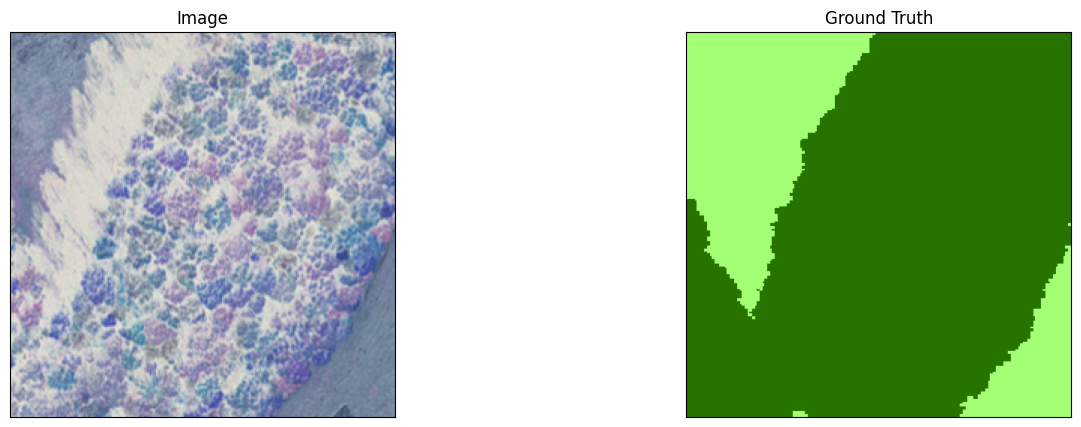

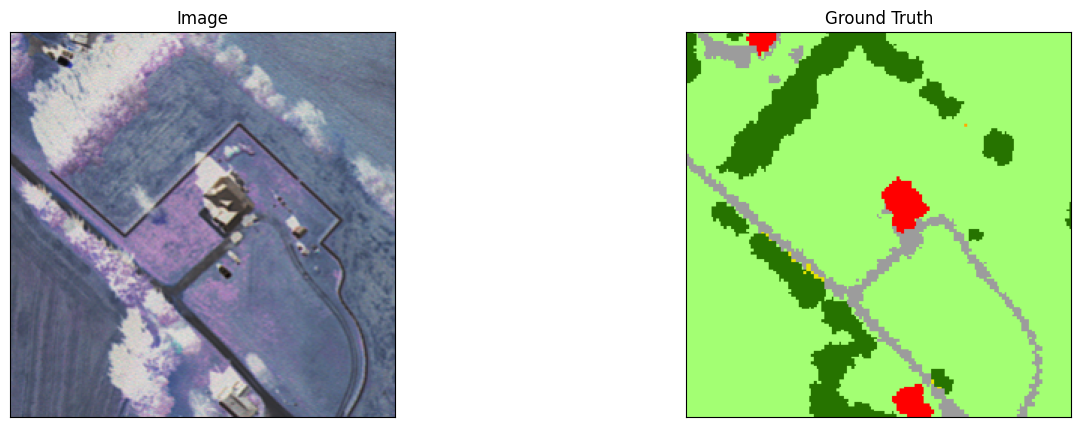

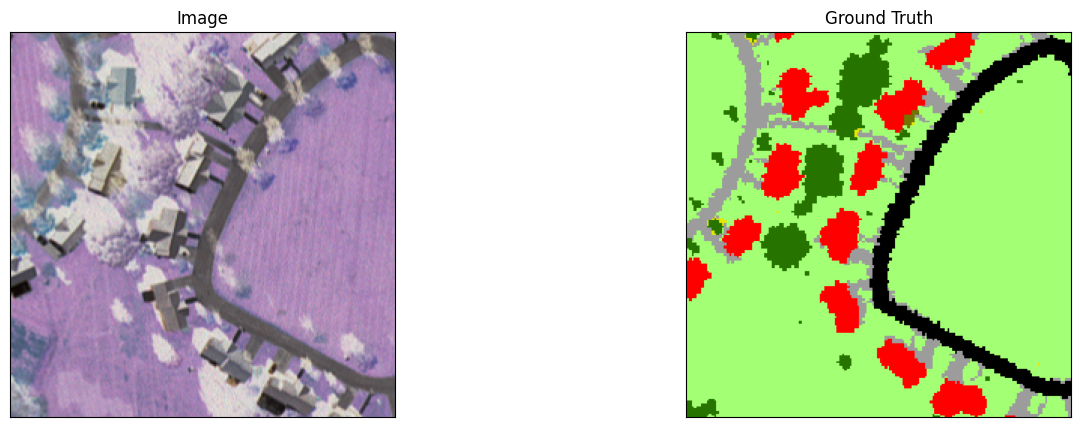

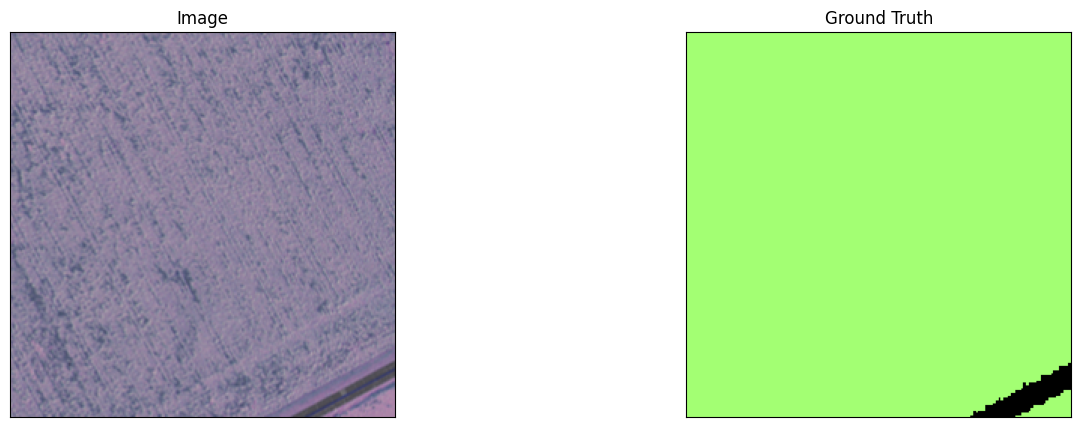

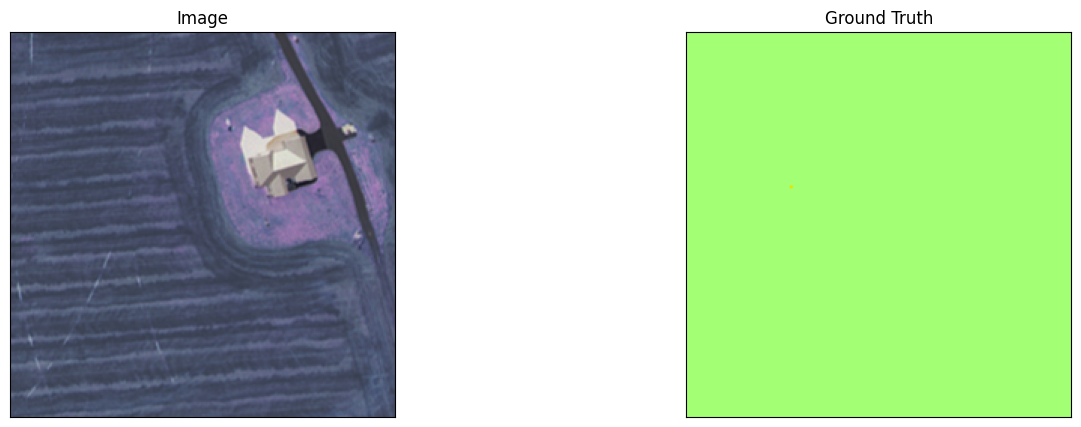

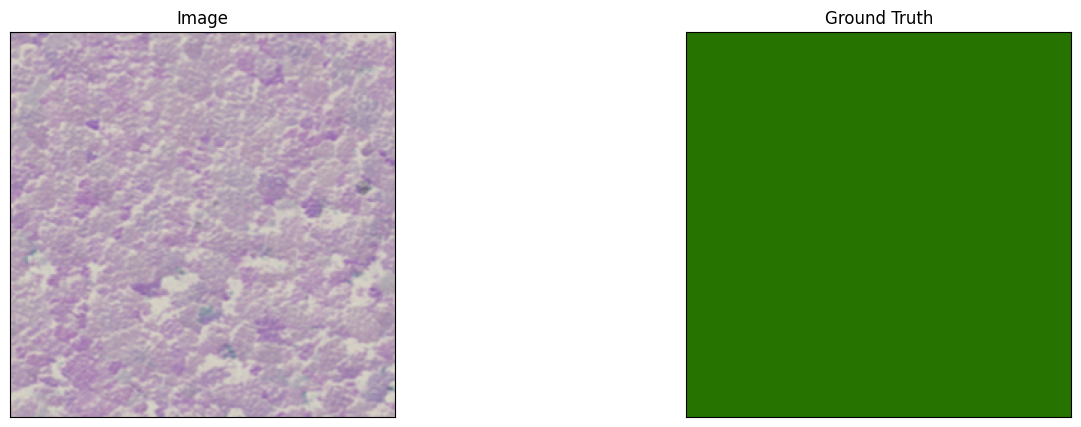

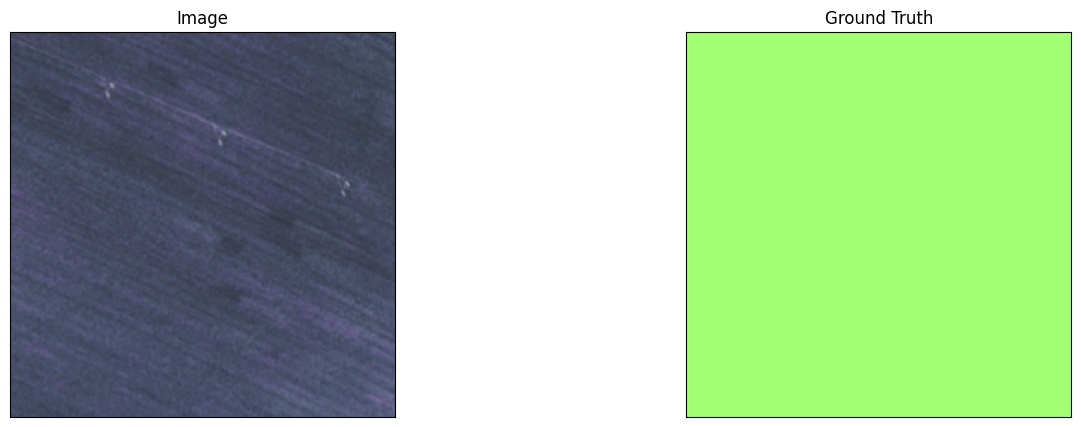

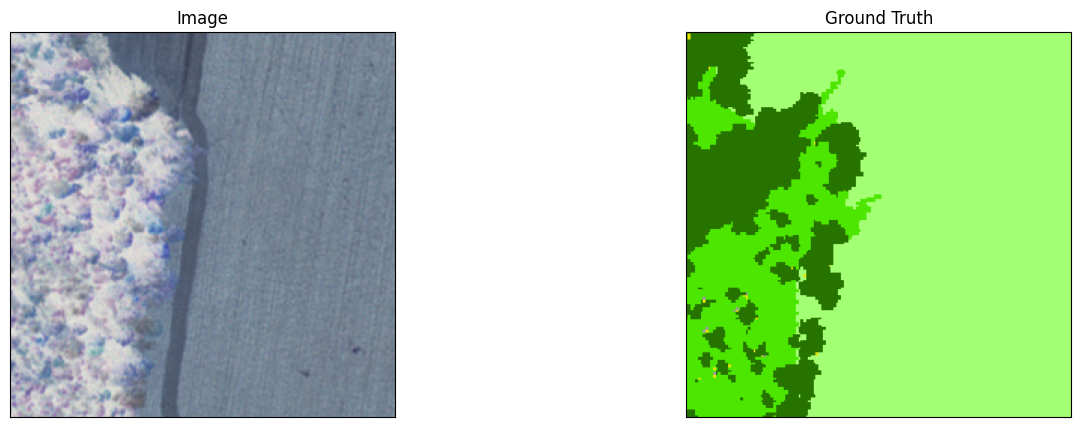

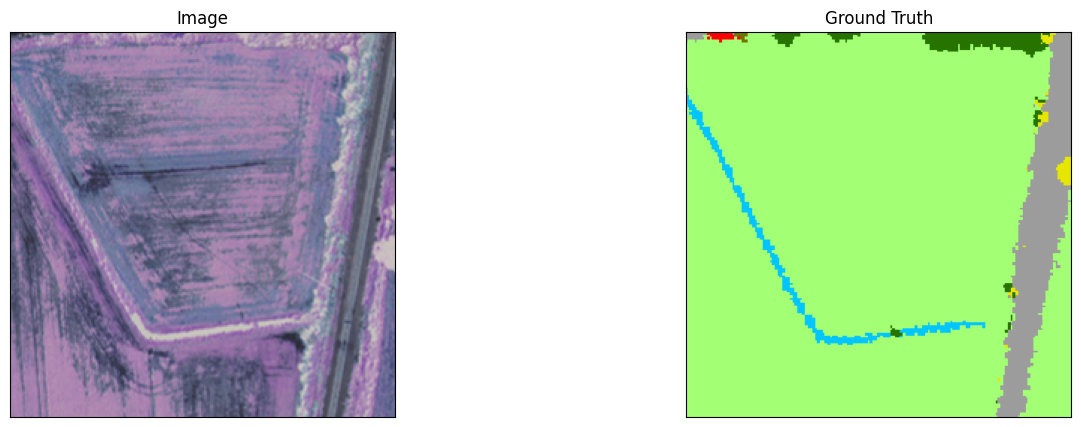

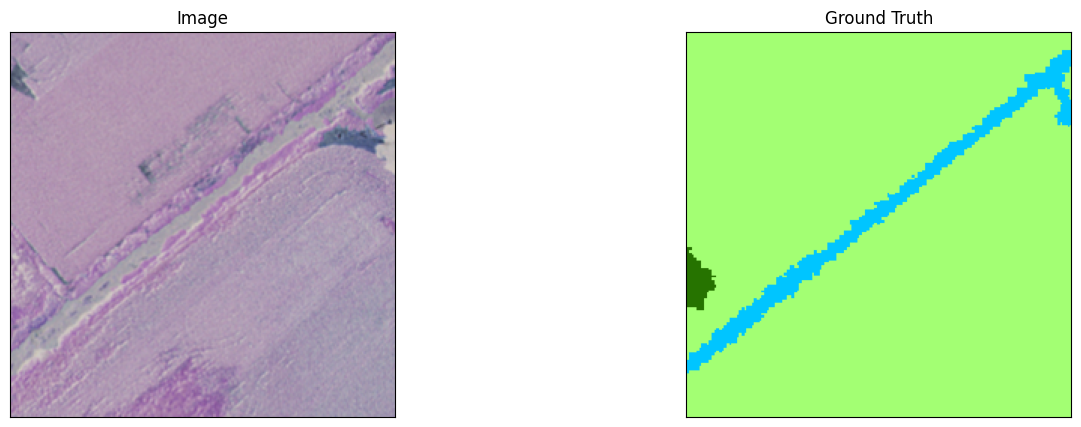

In [129]:
# visualize a set of 10 samples
n = 0
for sample in dataloader:
    if n == 10:
        break
    image, gt_mask = sample['image'], sample['mask']
    
    gt_mask = colour_code_segmentation(gt_mask, cmap)
        
    visualize(
        image=reverse_transform(image.squeeze()[:3]),
        ground_truth = gt_mask.squeeze(),
    )
    n += 1

## Train Model

In [130]:
# training from a checkpoint if available, otherwise from start
start = timeit.default_timer() # Measuring the time
#torch.mps.synchronize()

checkpoint_file = os.path.join(TEST_DIR, 'torchgeo_trained.ckpt') 

if os.path.isfile(checkpoint_file):
    print('Resuming training from previous checkpoint...')
    trainer.fit(
        model=task, 
        datamodule=datamodule,
        ckpt_path=checkpoint_file
    )
else:
    print('Starting training from scratch...')
    trainer.fit(
        model=task,
        datamodule = datamodule,
    )
    
print("The time taken to train was: ", timeit.default_timer() - start)


  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DeepLabV3Plus    | 26.7 M | train
1 | criterion     | FocalLoss        | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.736   Total estimated model params size (MB)
217       Modules in train mode
0         Modules in eval mode


Starting training from scratch...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'NAIPImages' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", lin

RuntimeError: DataLoader worker (pid(s) 15430, 15431, 15432, 15433, 15434, 15435, 15436, 15437, 15438, 15439) exited unexpectedly